In [36]:
import pandas as pd
import dvc.api
from tqdm import tqdm

In [2]:
from copy import deepcopy
import hashlib
from collections import OrderedDict
import json
def sortOD(od):
    res = OrderedDict()
    for k, v in sorted(od.items()):
        if isinstance(v, dict):
            res[k] = sortOD(v)
        else:
            res[k] = deepcopy(v)
    return res

In [3]:
df_metadata = pd.read_csv('../../../attribute_extraction_metadata_template/Initial Attribute Definition for First Release - UPDATED SHEET .csv')

In [4]:
df_metadata = df_metadata[['category', 'category_id', 'attribute_field', 'category_attributevalue', 'description', 'max_multi_select', 'usage', 'entry mode']]

In [5]:
metadata_category = set(df_metadata.category)
metadata_category_ids = set(df_metadata.category_id)

In [6]:
category2config = {}
for i in metadata_category:
    df_tmp = df_metadata[df_metadata.category == i]
    category2config[i] = sorted(df_tmp.to_dict('records'), key=lambda x: x['attribute_field'])
categoryid2config = {}
for i in metadata_category_ids:
    df_tmp = df_metadata[df_metadata.category_id == i]
    categoryid2config[i] = sorted(df_tmp.to_dict('records'), key=lambda x: x['attribute_field'])

In [48]:
# extract all attributes
category2config_multiselect = {}
for i in tqdm(metadata_category):
    df_tmp = df_metadata[df_metadata.category == i].copy()
    df_tmp['entry mode'] = df_tmp['entry mode'].replace({'single_selection_only': 'multi_selection_only'})
    df_tmp.loc[(df_tmp['entry mode'] == 'multi_selection_only'), "max_multi_select"] = 100.0
    category2config_multiselect[i] = sorted(df_tmp.to_dict('records'), key=lambda x: x['attribute_field'])
categoryid2config_multiselect = {}
for i in tqdm(metadata_category_ids):
    df_tmp = df_metadata[df_metadata.category_id == i].copy()
    df_tmp['entry mode'] = df_tmp['entry mode'].replace({'single_selection_only': 'multi_selection_only'})
    df_tmp.loc[(df_tmp['entry mode'] == 'multi_selection_only'), "max_multi_select"] = 100.0
    categoryid2config_multiselect[i] = sorted(df_tmp.to_dict('records'), key=lambda x: x['attribute_field'])

100%|██████████| 2658/2658 [00:05<00:00, 455.67it/s]


In [7]:
df_tax = pd.read_json(dvc.api.get_url(
    'datasets/data/taxonomy/wish_newtax.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [8]:
tax2id = {}
for i in df_tax.to_dict('records'):
    if len(i['category_path']) > 0:
        tax2id[i['category_path']] = int(i['id'])

# sample file

In [56]:
df_samples = pd.read_csv('sdt887_product_attribution_data_one_listing_per_leaf_node__20230111.csv')

In [57]:
df_samples.head(2)

,product_id,category_id,category_name,category_path,L1,L2,num_extra_photos,title,product_description,main_image_url
0,60f1d9657dd37ab3cbb26868,5504,Axes,Tools > Hand Tools > Axes,Tools,Tools > Hand Tools,9,"Axe holder, axe stand, Leviathan axe, God of W...","Axe holder, axe stand, Leviathan axe, God of W...",https://canary.contestimg.wish.com/api/webimag...
1,6184dc13dfb278fe92818499,2939,Pastry Brushes,"Home & Garden > Kitchen, Dining & Bar > Bakewa...",Home & Garden,"Home & Garden > Kitchen, Dining & Bar",8,New silicone baking pastry tool oil brush high...,"Welcome to my shop, I wish you a happy shoppin...",https://canary.contestimg.wish.com/api/webimag...


In [7]:
df_samples = df_samples[df_samples.category_path.apply(lambda x: x in metadata_category)]
df_samples = df_samples.sample(10, random_state=42)

In [10]:
res = []
for i in df_samples[['product_id', 'category_id', 'category_path', 'title', 'product_description', 'main_image_url']].to_dict('records'):
    i['text'] = \
f"""Title: {i['title']}
Description: {i['product_description']}"""
    i['attribute_config'] = category2config[i['category_path']]
    task_json = json.dumps(sortOD(i)).encode('utf-8')
    task_id = hashlib.md5(task_json).hexdigest()
    i['task_id'] = f"product_attribution_md_{task_id}"
    i['preloading_result'] = None
    res.append(i)

In [11]:
pd.DataFrame(res).to_json('example_offshore_input_listing_attr_extract_v2.json', lines=True, orient='records')

# demo file

In [58]:
df_samples_orig_text = pd.read_json(dvc.api.get_url(
    'datasets/data/wish_attr_extract_label/appen/input_batch/appen_product_attribution_batch1_text.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)
df_samples_orig_textimg = pd.read_json(dvc.api.get_url(
    'datasets/data/wish_attr_extract_label/appen/input_batch/appen_product_attribution_batch2_text_image.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [59]:
pid2cid = {}
for i in df_samples_orig_text[['product_id', 'category_id']].to_dict('records'):
    pid2cid[i['product_id']] = int(i['category_id'])
for i in df_samples_orig_textimg[['product_id', 'category_id']].to_dict('records'):
    pid2cid[i['product_id']] = int(i['category_id'])

In [60]:
df_samples = pd.read_csv(dvc.api.get_url(
    'datasets/data/wish_attr_extract_label/appen/input_batch_processed/appen_product_attribution_batch1.csv',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
))

In [61]:
df_samples = df_samples[df_samples.product_id.apply(lambda x: x in pid2cid)]

In [62]:
df_samples['category_id'] = df_samples['product_id'].apply(lambda x: pid2cid[x])

In [64]:
df_samples = df_samples[df_samples.category_id.apply(lambda x: x in categoryid2config)]
df_samples = df_samples.sample(10, random_state=42)

In [66]:
res = []
for i in df_samples[['product_id', 'category_id', 'category_path', 'title', 'product_description', 'main_image_url']].to_dict('records'):
    i['text'] = \
f"""Title: {i['title']}
Description: {i['product_description']}"""
    i['attribute_config'] = categoryid2config[i['category_id']]
    task_json = json.dumps(sortOD(i)).encode('utf-8')
    task_id = hashlib.md5(task_json).hexdigest()
    i['task_id'] = f"product_attribution_md_{task_id}"
    i['preloading_result'] = None
    res.append(i)

In [68]:
pd.DataFrame(res).to_json('offshore_md/demo_product_attr_extract_md_02272023.json', lines=True, orient='records')

# 1st production batch

In [13]:
df = pd.concat([ 
    pd.read_json(dvc.api.get_url(
        'datasets/data/wish_attr_extract_label/processed/appen_020323_030323_delivered_030623_validated_product_attr_textandimg_test.json', 
        repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
    ), lines=True), 
    pd.read_json(dvc.api.get_url(
        'datasets/data/wish_attr_extract_label/processed/appen_020323_030323_delivered_030623_validated_product_attr_textonly_test.json', 
        repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
    ), lines=True)
])

In [15]:
df_sample = df.sample(1000, random_state=42)

In [21]:
df_sample['category_id'] = df_sample['category'].apply(lambda x: tax2id[x])

In [23]:
len(df_sample)

1000

In [25]:
df_sample = df_sample[df_sample.category_id.apply(lambda x: x in categoryid2config)]
len(df_sample)

1000

In [34]:
df_sample = df_sample.rename(columns={
    'pid': 'product_id', 
    'description': 'product_description', 
    'category': 'category_path',
    'main_img_url': 'main_image_url'
})

In [35]:
res = []
for i in df_sample[['product_id', 'category_id', 'category_path', 'title', 'product_description', 'main_image_url']].to_dict('records'):
    i['text'] = \
f"""Title: {i['title']}
Description: {i['product_description']}"""
    i['attribute_config'] = categoryid2config[i['category_id']]
    task_json = json.dumps(sortOD(i)).encode('utf-8')
    task_id = hashlib.md5(task_json).hexdigest()
    i['task_id'] = f"product_attribution_md_{task_id}"
    i['preloading_result'] = None
    res.append(i)

In [38]:
pd.DataFrame(res).to_json('input/product_attr_extract_md_03072023.json', lines=True, orient='records')

# 2nd production batch

In [9]:
df = pd.concat([ 
    pd.read_csv(dvc.api.get_url(
        'datasets/data/wish_attr_extract_label/appen/output_batch_correct_v5/product_attribution_till_032423_invalid_units_fixed.csv', 
        repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
    )), 
    pd.read_csv(dvc.api.get_url(
        'datasets/data/wish_attr_extract_label/appen/output_batch_correct_v5/product_attribution_till_032423_valid_units.csv', 
        repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
    ))
])

In [11]:
df.loc[~df.final_output_corrected.isna(), 'final_output'] = df.loc[~df.final_output_corrected.isna(), 'final_output_corrected']
del df['final_output_corrected']
del df['explanation']

In [15]:
len(df)

51543

<Axes: ylabel='sample_method'>

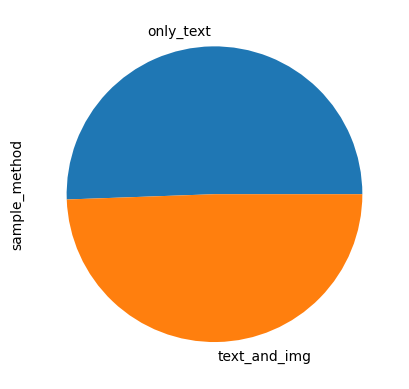

In [13]:
df.sample_method.value_counts().plot.pie()

In [54]:
df_onlytext = df[df.sample_method == 'only_text']

In [55]:
len(df_onlytext)

26066

In [56]:
len(set(df_onlytext.l2_category))

24

<Axes: ylabel='l2_category'>

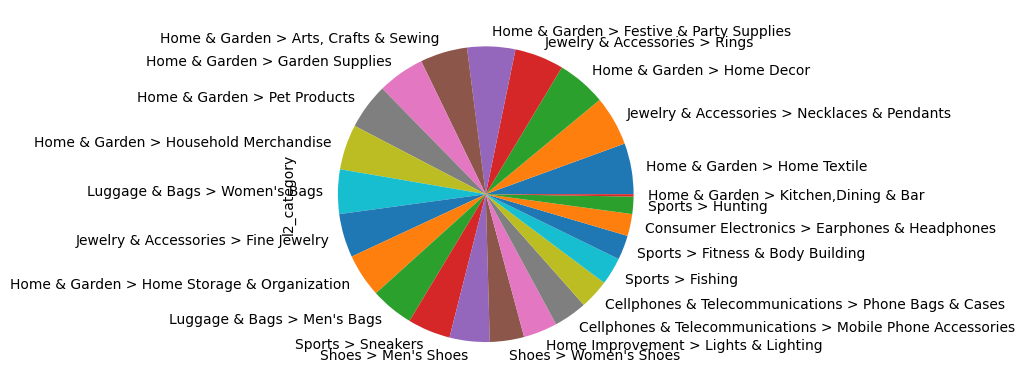

In [57]:
df_onlytext.l2_category.value_counts().plot.pie()

In [58]:
df_onlytext.product_category.value_counts()

Jewelry & Accessories > Rings                                                       1402
Luggage & Bags > Men's Bags > Backpacks                                              616
Cellphones & Telecommunications > Phone Bags & Cases > Phone Pouches                 549
Jewelry & Accessories > Necklaces & Pendants > Pendants                              434
Consumer Electronics > Earphones & Headphones > Bluetooth Earphones & Headphones     401
                                                                                    ... 
Home & Garden > Kitchen,Dining & Bar > Bakeware > Cookie Cutters                       1
Home & Garden > Pet Products > Reptile & Amphibian Supplies > Terrariums               1
Home & Garden > Garden Supplies > Garden Buildings > Playhouses                        1
Home & Garden > Garden Supplies > Pest Control > Bug Zappers                           1
Home & Garden > Home Textile > Bedding > Mattress Toppers                              1
Name: product_categor

In [59]:
df_onlytext[df_onlytext.product_category == 'Home & Garden > Home Textile > Bedding > Mattress Toppers'].to_dict('records')

[{'label_ordering': 50533,
  'sample_method': 'only_text',
  'product_id': '5ff9d971ede21c7ea9c4af85',
  'title': 'Memory Foam Solutions UBSMSF915ZCP2 Topper Cover and Two Classic Contour Pillows and Full / Double Size 1.5 Inch Thick 3 Pound Density Visco Elastic Memory Foam Mattress Bed Topper Made in the USA',
  'product_description': "<p>Our mission is to make you more comfortable so you can sleep better night after night and awake refreshed each and every day&#46; We are constantly developing new technologies in our laboratories, utilizing proprietary designs and groundbreaking materials that will increase your level of comfort and improve the therapeutic support you need to maintain restful sleep for many wonderful blissful years of sleeping&#46; If you want the most restful sleep you can get to and want to reinvigorate your life, discover what solutions the technologically advanced leader in comfort bedding has in store for you&#46; Memory Foam Solutions mattresses, toppers and p

In [60]:
df_onlytext['category'] = df_onlytext['product_category']
df_onlytext['category_id'] = df_onlytext['category'].apply(lambda x: tax2id[x])

/tmp/ipykernel_1097/859694556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_onlytext['category'] = df_onlytext['product_category']
/tmp/ipykernel_1097/859694556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_onlytext['category_id'] = df_onlytext['category'].apply(lambda x: tax2id[x])


In [61]:
df_onlytext = df_onlytext[df_onlytext.category_id.apply(lambda x: x in categoryid2config_multiselect)]


In [62]:
len(df_onlytext)

26066

In [64]:
df_onlytext.head(1)

,label_ordering,sample_method,product_id,title,product_description,main_image_url,product_category,l2_category,rater1_output,rater2_output,...,rater1_no_attributes,rater1_unlisted_value,rater2_no_attributes,rater2_unlisted_value,rater3_no_attributes,rater3_unlisted_value,title_original,final_output,category,category_id
1,145,only_text,60d3bdaf6dbb5f0054f20a81,Esource Parts - Braided Micro USB Cable for An...,A special type of adhesive keeps your Samsung ...,NaN,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,...,NaN,NaN,NaN,NaN,NaN,NaN,Esource Parts - Braided Micro USB Cable for An...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,1271


In [65]:
df_onlytext = df_onlytext.rename(columns={
    'category': 'category_path'
})

In [67]:
res = []
for i in df_onlytext[['product_id', 'category_id', 'category_path', 'title', 'product_description', 'main_image_url']].to_dict('records'):
    i['text'] = \
f"""Title: {i['title']}
Description: {i['product_description']}"""
    i['attribute_config'] = categoryid2config_multiselect[i['category_id']]
    task_json = json.dumps(sortOD(i)).encode('utf-8')
    task_id = hashlib.md5(task_json).hexdigest()
    i['task_id'] = f"product_attribution_md_{task_id}"
    i['preloading_result'] = None
    res.append(i)

In [68]:
pd.DataFrame(res).to_json('input/product_attr_extract_md_03252023.json', lines=True, orient='records')

In [70]:
len(res)

26066

In [71]:
len(set([i['task_id'] for i in res]))

26066

In [72]:
older_task_ids = set(pd.read_json('input/product_attr_extract_md_03072023.json', lines=True).task_id)

In [73]:
len(older_task_ids)

1000

In [74]:
len(older_task_ids.intersection(set([i['task_id'] for i in res])))

0